#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 8**
###**Máquina de Vector Soporte - Support Vector Machine(SVM)**


**Nombres y matrículas de los integrantes del equipo:**

*  Rafael J. Mateo C., A01793054 
*  Daniel Chavarria Barrientos A01331204 
*  Enrique Ricardo García Hernández - A01315428
*  Omar Nayib García Sabag - A01793008


En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

In [401]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from sklearn.metrics import  make_scorer, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

A continuación definimos algunas funciones que estaremos utilizando para el ejericio.

In [462]:
# Funciones para metricas
#accuracy (VP+VN)/(VP+VN+FP+FN)

eps = np.finfo(np.float32).eps #Epsilon para evitar división entre cero

def mi_accuracy(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)
  accuracy = (cm[1,1]+cm[0,0])/(cm[1,1]+cm[0,0]+cm[0,1]+cm[1,0])
  return accuracy

#precision VP/(VP+FP)
def mi_precision(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)
  precision=cm[1,1]/(cm[1,1]+cm[0,1] + eps)
  return precision

#recall / exhaustividad VP/(VP+FN)
def mi_recall(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)
  recall=cm[1,1]/(cm[1,1]+cm[1,0] + eps)
  return recall

#f1 score 2VP/(2VP+FP+FN)
def mi_f1score(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)
  f1score= 2 * cm[1,1]/(2*cm[1,1]+cm[1,0]+cm[0,1])
  return f1score

def calc_specificity(yreal, ypred):
  tp, fp, fn, tn = confusion_matrix(yreal, ypred).ravel()
  return tn / (tn + fp + eps)

def calc_sensitivity(yreal, ypred):
  tp, fp, fn, tn = confusion_matrix(yreal, ypred).ravel()
  return tp/(tp + fn + eps)

def calc_gmean(yreal, ypred):
     return (calc_specificity(yreal, ypred)* mi_recall(yreal, ypred)) ** 1/2


#Función para imprimir los scores
def print_scores(score):
  print('Train: %.3f (%.4f)\nTest: %.3f (%.4f)\n' % (
  np.mean(score['train_score']),
  np.std(score['train_score']),
  np.mean(score['test_score']),
  np.std(score['test_score']),
  ))

#### **Ejercicio 1 - Importación de los datos y partición** 

Comencemos con la importación de los datos. Como se puede ver, es necesario nombrar las columnas ya que no vienen en el archivo

In [463]:
#Nombres de las columnas
colnames=[f"A{i+1}" for i in range(15)]

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat", sep= " ", names=colnames, header=None)
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


Verificamos la cantidad de filas y columnas de los datos

In [464]:
df.shape

(690, 15)

Realizamos una copia de los datos para seguridad y definimos las X y Y

In [465]:
#Copiamos el df para no manipular datos originales
df_copy = df.copy()

#Definimos las Xs y ys
X = df_copy.iloc[:,:14]
y = df_copy.iloc[:,-1:]

In [466]:
X.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159


In [467]:
X.dtypes

A1       int64
A2     float64
A3     float64
A4       int64
A5       int64
A6       int64
A7     float64
A8       int64
A9       int64
A10      int64
A11      int64
A12      int64
A13      int64
A14      int64
dtype: object

In [468]:
y.head()

,A15
0,0
1,0
2,0
3,1
4,1


Ahora realizamos la partición

In [469]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.15, random_state = 0)

#### **Ejercicio 2 - Análisis Exploratorio y Limpieza**

Realizamos un análisis descriptivo de los datos, empezando por la definición del tipo de cada variable.

Tipo de variables:
- A1: Categórica. 2 clases
- A2: Continua
- A3: Continua
- A4: Categórica. 3 clases
- A5: Categórica. 14 clases
- A6: categórica. 9 clases
- A7: Continua
- A8: Categórica. 2 clases
- A9: Categórica. 2 clases
- A10: Continua
- A11: Categórica. 2 clases
- A12: Categórica. 3 clases
- A13: Continua
- A14: Continua
- A15: Atributo (boolena)

In [470]:
#Para las variables categóricas imputaríamos el valor que más se repite, para las variables continuas la mediana
numeric_cols = ['A2','A3','A7','A10','A13','A14']
cat_cols = ['A1','A4','A5','A6','A8','A9','A11','A12']

In [471]:
#Generación de estadísticos
Xtrain.describe(include='all')

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
count,586.000,586.000,586.000,586.000,586.000,586.000,586.000,586.000,586.000,586.000,586.000,586.000,586.000,586.000
mean,0.683,31.672,4.780,1.768,7.258,4.609,2.329,0.538,0.427,2.449,0.462,1.925,181.157,984.906
std,0.466,11.871,5.009,0.431,3.697,1.956,3.485,0.499,0.495,5.029,0.499,0.300,175.277,5358.882
min,0.000,13.750,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000
25%,0.000,22.670,1.000,2.000,4.000,4.000,0.165,0.000,0.000,0.000,0.000,2.000,70.750,1.000
50%,1.000,28.710,2.812,2.000,8.000,4.000,1.000,1.000,0.000,0.000,0.000,2.000,157.000,5.000
75%,1.000,38.250,7.500,2.000,9.750,5.000,2.947,1.000,1.000,3.000,1.000,2.000,266.000,351.750
max,1.000,80.250,28.000,3.000,14.000,9.000,28.500,1.000,1.000,67.000,1.000,3.000,2000.000,100001.000


Confirmamos la presencia de valores vacíos o nulos

In [472]:
Xtrain.isna().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
dtype: int64

No existen datos nulos o vacíos. Ahora revisemos la estructura de los datos.

In [473]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 242 to 684
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      586 non-null    int64  
 1   A2      586 non-null    float64
 2   A3      586 non-null    float64
 3   A4      586 non-null    int64  
 4   A5      586 non-null    int64  
 5   A6      586 non-null    int64  
 6   A7      586 non-null    float64
 7   A8      586 non-null    int64  
 8   A9      586 non-null    int64  
 9   A10     586 non-null    int64  
 10  A11     586 non-null    int64  
 11  A12     586 non-null    int64  
 12  A13     586 non-null    int64  
 13  A14     586 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 68.7 KB


Ahora construyamos algunos diagramas de barra para analizar las variables categóricas.

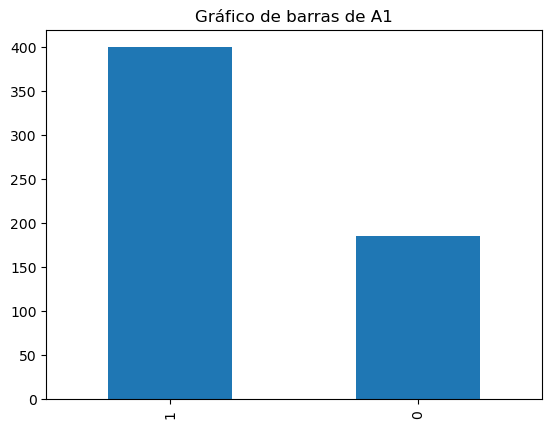

1    0.683
0    0.317
Name: A1, dtype: float64
1    400
0    186
Name: A1, dtype: int64


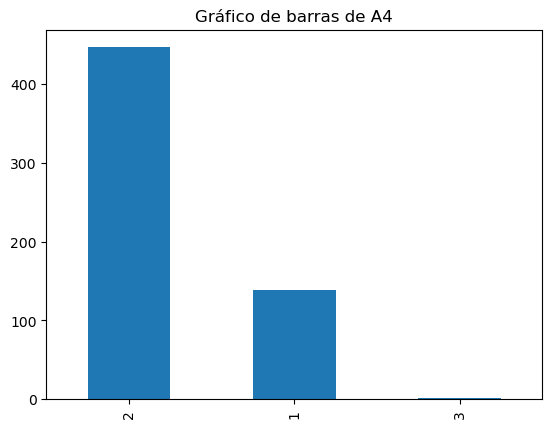

2    0.761
1    0.235
3    0.003
Name: A4, dtype: float64
2    446
1    138
3      2
Name: A4, dtype: int64


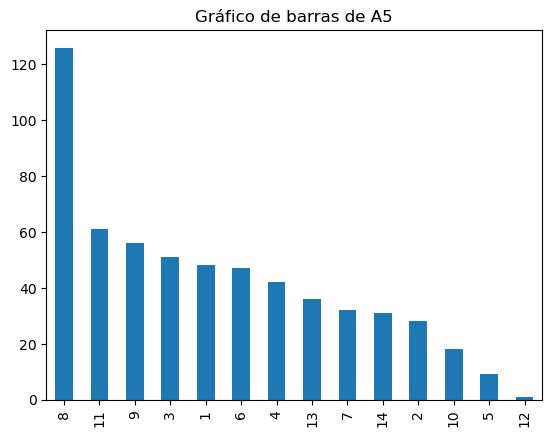

8     0.215
11    0.104
9     0.096
3     0.087
1     0.082
6     0.080
4     0.072
13    0.061
7     0.055
14    0.053
2     0.048
10    0.031
5     0.015
12    0.002
Name: A5, dtype: float64
8     126
11     61
9      56
3      51
1      48
6      47
4      42
13     36
7      32
14     31
2      28
10     18
5       9
12      1
Name: A5, dtype: int64


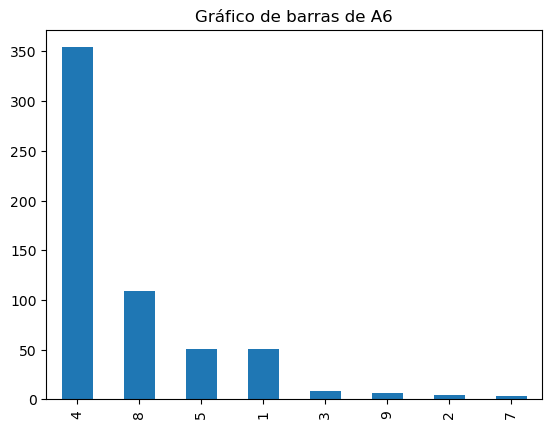

4    0.604
8    0.186
5    0.087
1    0.087
3    0.014
9    0.010
2    0.007
7    0.005
Name: A6, dtype: float64
4    354
8    109
5     51
1     51
3      8
9      6
2      4
7      3
Name: A6, dtype: int64


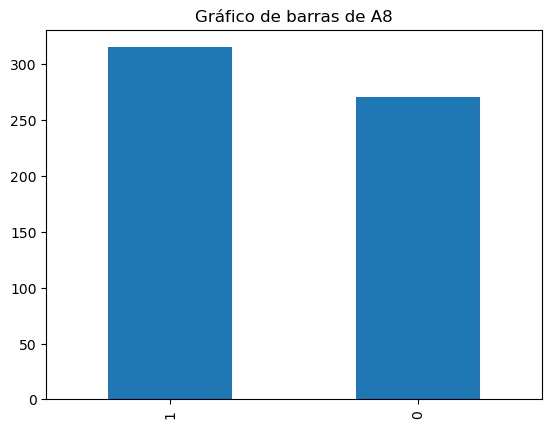

1    0.538
0    0.462
Name: A8, dtype: float64
1    315
0    271
Name: A8, dtype: int64


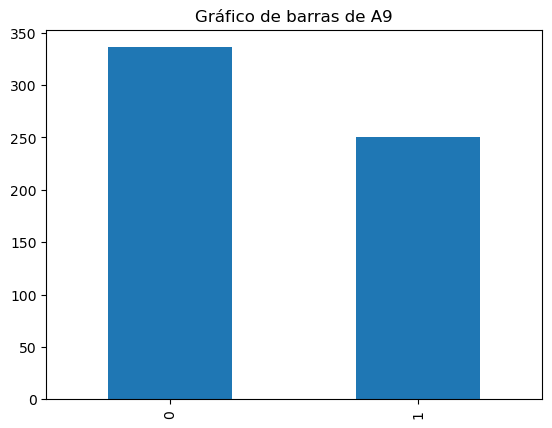

0    0.573
1    0.427
Name: A9, dtype: float64
0    336
1    250
Name: A9, dtype: int64


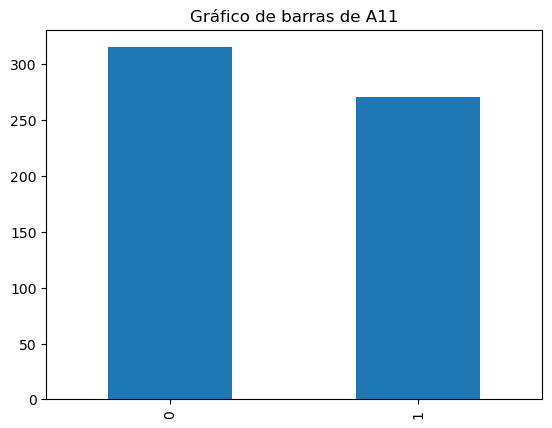

0    0.538
1    0.462
Name: A11, dtype: float64
0    315
1    271
Name: A11, dtype: int64


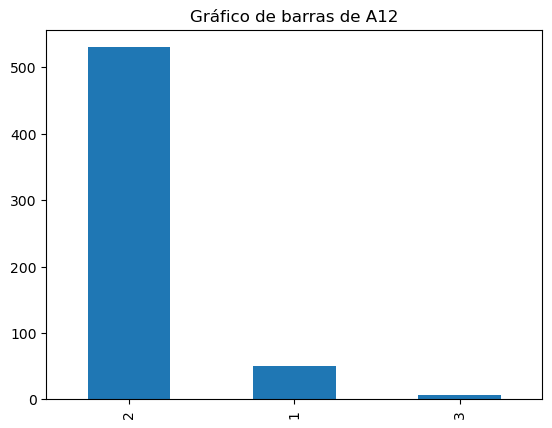

2    0.904
1    0.085
3    0.010
Name: A12, dtype: float64
2    530
1     50
3      6
Name: A12, dtype: int64


In [474]:
for variable in cat_cols:
  tab=Xtrain[variable].value_counts()
  porc_tab=Xtrain[variable].value_counts()/tab.sum()
  Xtrain[variable].value_counts().plot(kind='bar',title='Gráfico de barras de' f' {variable}')
  plt.show()
  print(porc_tab)
  print(tab)

In [475]:
#Agrupaciones de valores para aquellas variables catagóricas con menos del 5% de población
Xtrain['A4'] = Xtrain['A4'].map({2:2,1:1,3:1})
Xtrain['A4'].value_counts()/Xtrain['A4'].shape

Xtrain['A5'] = Xtrain['A5'].map({1:1,2:2,3:3,4:4,5:2,6:6,7:7,8:8,9:9,10:2,11:11,12:2,13:13,14:2})
Xtrain['A5'].value_counts()/Xtrain['A5'].shape

Xtrain['A6'] = Xtrain['A6'].map({1:1,2:2,3:2,4:4,5:5,6:6,7:2,8:8,9:2})
Xtrain['A6'].value_counts()/Xtrain['A6'].shape

Xtrain['A12'] = Xtrain['A12'].map({1:1,2:2,3:1})
Xtrain['A12'].value_counts()/Xtrain['A12'].shape

2    0.904
1    0.096
Name: A12, dtype: float64

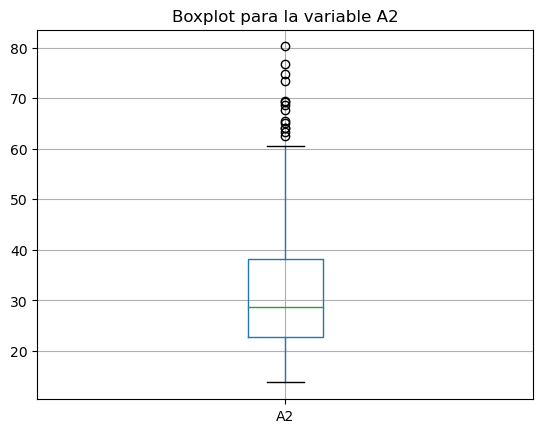

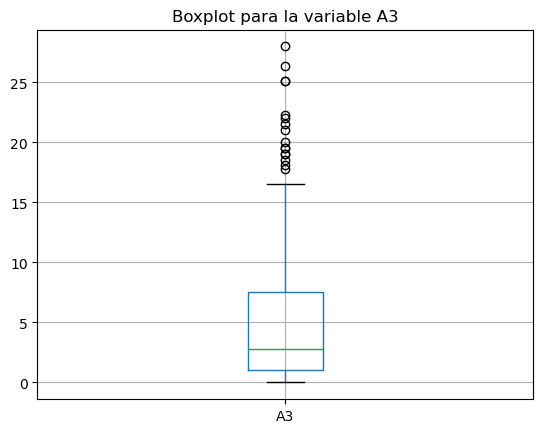

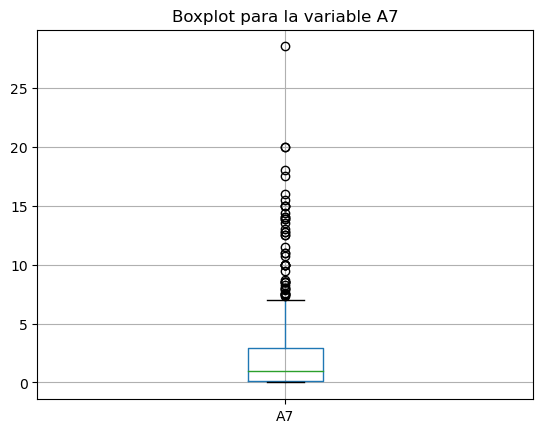

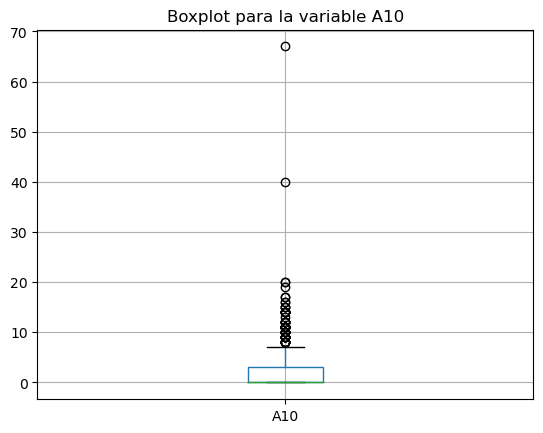

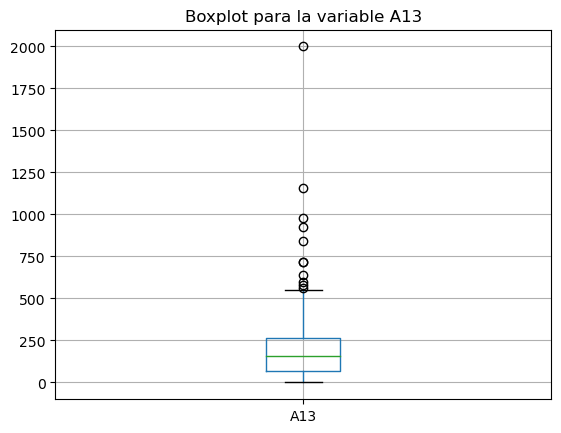

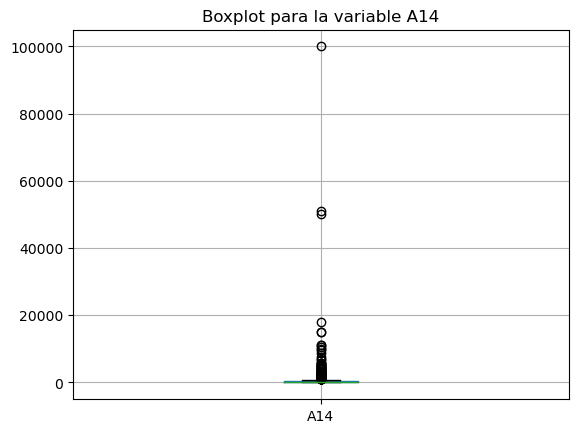

In [476]:
for var in numeric_cols:
    plt.title(f'Boxplot para la variable {var}')
    Xtrain[[var]].boxplot()
    plt.show()

De los gráficos anteriores se observan que los datos de las variables tienen un sesgo positivo. También se observan valores atípicos para cada una de estas variables.

Ahora evaluemos las ys para determinar si existe algún problema de desbalanceo.

In [477]:
ytrain.value_counts()

A15
0      325
1      261
dtype: int64

De lo anterior se observa que la clase minoritaria representa cerca del 44% del total de los datos.

In [478]:
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())
                                ]
                      )
# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [479]:
Xtrain_prep = preprocessor.fit_transform(Xtrain)
Xtest_prep  = preprocessor.transform(Xtest)

#### **Ejercicio 3 - Modelo Dummy**

Ahora buscaremos una línea base con el clasificador dummy y la estrategia 'stratified'. La razón por la cual se usa esta estrategia, es para que el clasificador haga mejores predicciones para la clase minoritaria. Como se observó en el apartado del análisis exploratorio, la clase minoritaria representa un 44% del total de los datos.

Por otro lado, también obtendremos 4 métricas distintas para el clasificador dummy.

In [480]:
#Los scorings a utilizar
scorings = {
    'accuracy': mi_accuracy, 
    'f1': mi_f1score, 
    'precision': mi_precision, 
    'recall': mi_recall,
    'gmean': calc_gmean
    }
#Donde almacenaremos los scores del clasificador dummy
scores = {}

dummy_clf = DummyClassifier(strategy="stratified")

#Entrenamos el modelo y predecimos los resultados
dummy_clf.fit(Xtrain_prep, ytrain)
y_pred = dummy_clf.predict(Xtrain_prep)

#Obtenemos las métricas
for name,scoring in scorings.items():
    scores[name] = scoring(ytrain, y_pred)

#Imprimimos las métricas en un dataframe
print('Métricas para el modelo dummy')
pd.DataFrame(data = scores, index = [0])



Métricas para el modelo dummy


,accuracy,f1,precision,recall,gmean
0,0.502,0.43,0.438,0.421,0.092


#### **Ejercicio 4 - Modelo de Vector de Soporte (SVM)**

Comencemos ahora buscando el mejor modelo de SVM, definiendo primero el kfold que estaremos utilizando

In [481]:

kfold = RepeatedStratifiedKFold(n_splits= 5, n_repeats= 5, random_state=42)

In [591]:
#Definimos el modelo
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("modelo",svm.SVC(probability=True))
        ])
best_models = {}

#parámetros que usaremos en el grid
param_grid = {
    'modelo__C': [0.01, 0.1,1, 10, 100],
    'modelo__gamma': [0.001,0.01, 0.1, 1],
    'modelo__class_weight': ['balanced', None],
    'modelo__shrinking': [True, False]
}

#Hacemos el grid con un loop para probar con diferentes métricas
for name,score in scorings.items():
    search =  GridSearchCV(pipeline,
    param_grid,
    n_jobs=-1,
    cv=kfold,
    scoring = make_scorer(score),
    )
    search.fit(Xtrain, ytrain.values.ravel())
    
    #Almacenamos el mejor estimador para usarlo más adelante
    best_models[name] = search.best_estimator_
   
    #Colocamos los resultados en un DF
    df_best_params = pd.DataFrame(
        data = [search.best_params_.values()], 
        index = [0],
        columns = (lambda keys: [key.split('__')[1] for key in keys] )(search.best_params_.keys()))

   #Imprimos las métricas
    print("Valor de la métrica %s con mejores parámetros: %0.3f:\n" % (name,search.best_score_))
    display(df_best_params)
    print('\n--------------------------------------------------\n')


Valor de la métrica accuracy con mejores parámetros: 0.861:



,C,class_weight,gamma,shrinking
0,100,None,0.01,True



--------------------------------------------------

Valor de la métrica f1 con mejores parámetros: 0.850:



,C,class_weight,gamma,shrinking
0,1,None,0.01,True



--------------------------------------------------

Valor de la métrica precision con mejores parámetros: 0.914:



,C,class_weight,gamma,shrinking
0,0.1,None,0.01,True



--------------------------------------------------

Valor de la métrica recall con mejores parámetros: 0.939:



,C,class_weight,gamma,shrinking
0,1,balanced,0.01,True



--------------------------------------------------

Valor de la métrica gmean con mejores parámetros: 0.365:



,C,class_weight,gamma,shrinking
0,1,None,0.01,True



--------------------------------------------------



Ahora obtengamos las métricas de la validación cruzada para cada uno de los modelos óptimos que se obtuvieron arriba.

In [592]:
#Aquí almacenamos las diferentes métricas
scores = {}

for name,scoring in scorings.items():

    score = cross_validate(
    estimator=best_models[name], 
    X=Xtrain,
    y=np.ravel(ytrain),
    cv=kfold,
    scoring=make_scorer(scoring), 
    return_train_score=True,
    n_jobs=-1)

    scores[name] = score

    print(f"Métrica %s para el modelo SVM \n" % name)
    print_scores(score)




Métrica accuracy para el modelo SVM 

Train: 0.927 (0.0072)
Test: 0.861 (0.0277)

Métrica f1 para el modelo SVM 

Train: 0.850 (0.0055)
Test: 0.850 (0.0239)

Métrica precision para el modelo SVM 

Train: 0.924 (0.0125)
Test: 0.914 (0.0465)

Métrica recall para el modelo SVM 

Train: 0.939 (0.0063)
Test: 0.939 (0.0253)

Métrica gmean para el modelo SVM 

Train: 0.364 (0.0045)
Test: 0.365 (0.0195)



Del punto anterior se aprecia que el modelo está sobreentrenado para las métricas accuracy y f1. Las métricas precision y recall muestra un buen desempeño y no se observa sobreentrenamiento.

Ahora analicemos los resultados de las métricas en un diagrama de caja

#### **Ejercicio 5 - Diagrama de Caja**

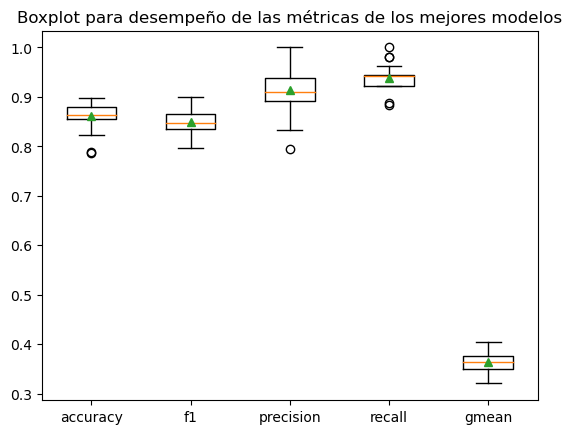

In [593]:
bpRecall = list()
names = list()
#Almacenamos los datos del diagrama en unas listas
for name,score in scores.items():
  names.append(name)
  bpRecall.append(score['test_score'])

#Graficamos el diagrama
plt.title("Boxplot para desempeño de las métricas de los mejores modelos")
plt.boxplot(bpRecall,labels=names,showmeans=True)
plt.show()


Del diagrama se observa que recall tiene poca variabilidad y una media más alta en comparación con las demás. también se puede observa algunos valores atípicos, por lo hubo casos donde el modelo tuvo algunas predicciones muy alejadas de la realidad.

La métrica que representa mayor variabilidad es la precisión, mientras que accuracy y f1 tienen un desempeño muy similar.

De lo anterior se concluye que el modelo del recall es el más adecuado desde el punto de vista de las métricas, sin embargo, la elección de la métrica debe hacerse también con base en las necesidades del negocio.

#### **Ejercicio 6 - Curvas de Aprendizaje**

Ahora evaluemos el desempeño de los modelos en función de sus curvas de aprendizaje. Primero comencemos definiendo algunas funciones para realizar el ploteo de las curvas.

In [485]:
def create_learning_curve(model, X, y, cv, scoring):
  pipe = Pipeline(steps = [
      ('preprocessor', preprocessor),
      ("model", model)
  ])

  #Define los train sizes
  train_sizes = np.linspace(0.1,1.0, 25)

  #Genera los valores para la curve
  return learning_curve(
      estimator = pipe, 
      X = X, y = y, 
      cv = cv,
      n_jobs = -1,
      train_sizes = train_sizes, 
      scoring = scoring )

def plot_learning_curve(model, X, y, cv, title, scoring = "accuracy"):
  
  train_sizes, train_score, test_score = create_learning_curve(model, X, y, cv, scoring)

  #Calculamos las medias y std
  train_mean = np.mean(train_score, axis = 1)
  train_std = np.std(train_score, axis = 1)

  test_mean = np.mean(test_score, axis = 1)
  test_std = np.std(test_score, axis = 1)

  #Graficamos las curvas
  plt.figure(figsize=(10,8))

  plt.plot(train_sizes, train_mean, color = "r",  marker = "o", markersize=5, label = "Training")
  plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.1, color = "r")

  plt.plot(train_sizes, test_mean, color = "g", linestyle ="--", markersize = 5, marker="+", label = "Validation")
  plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.1, color = "g")

  plt.grid()
  plt.xlabel("Train sizes")
  plt.ylabel("Score")
  plt.title(title)
  plt.legend(loc = "lower right")
  plt.show()



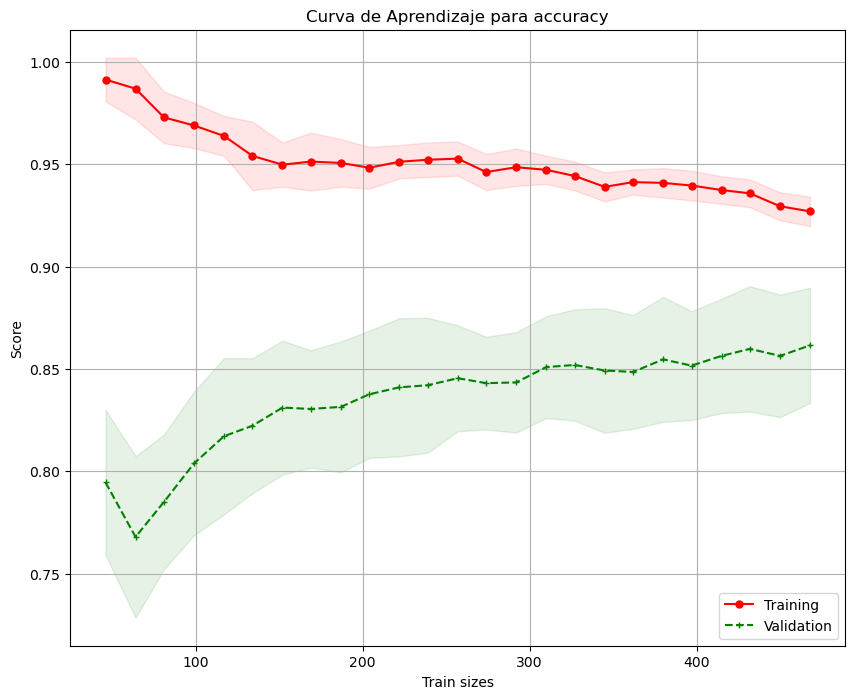

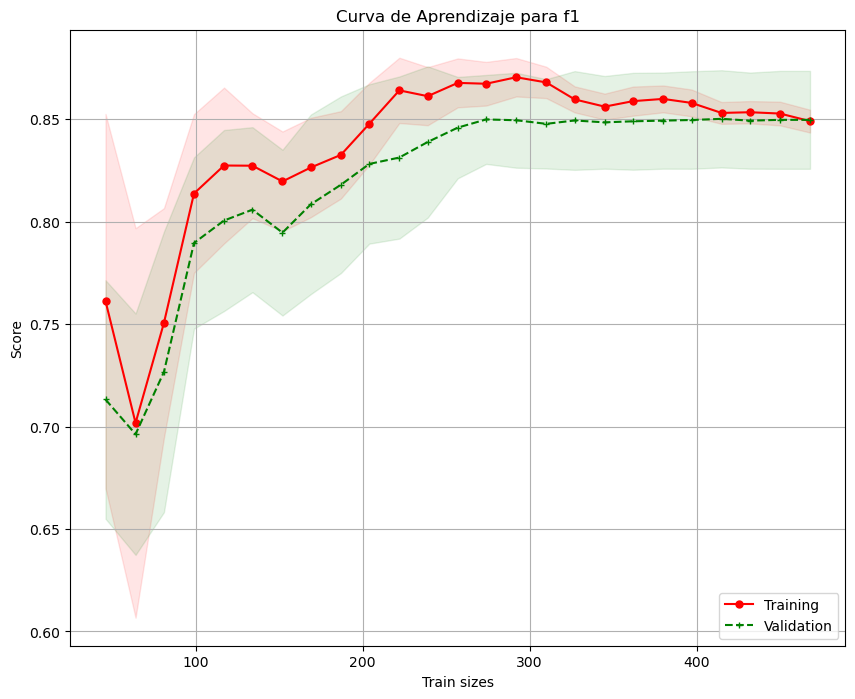

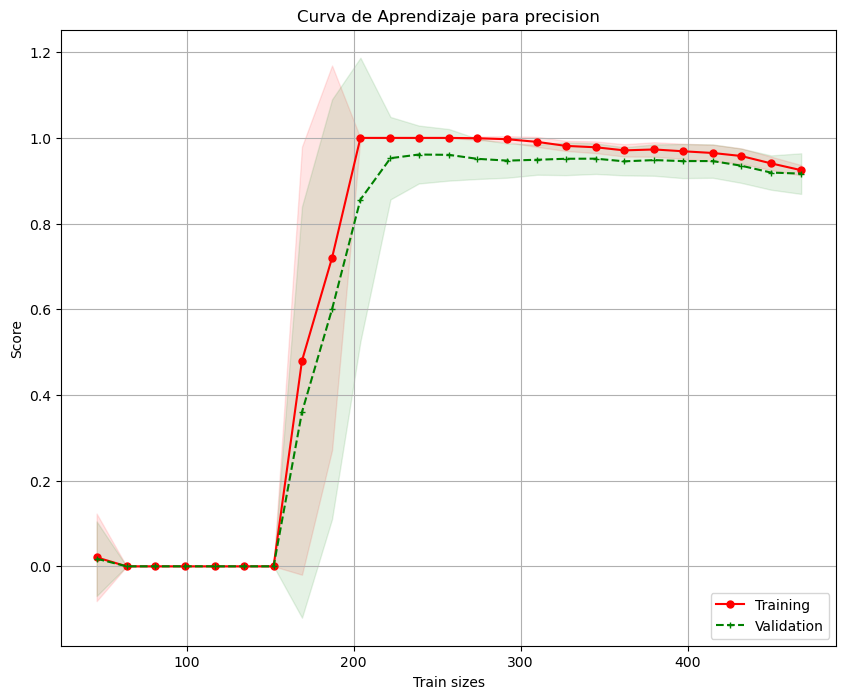

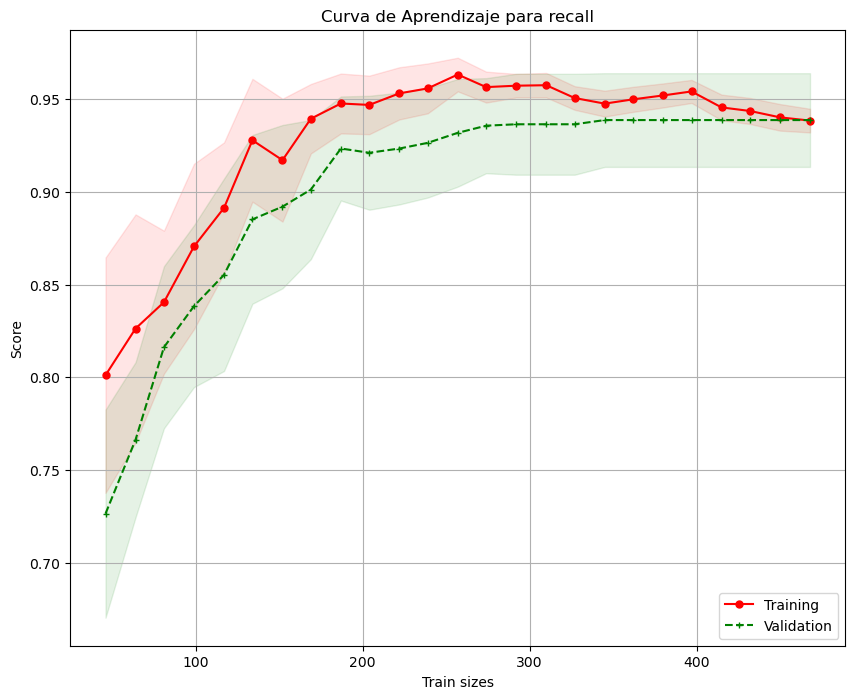

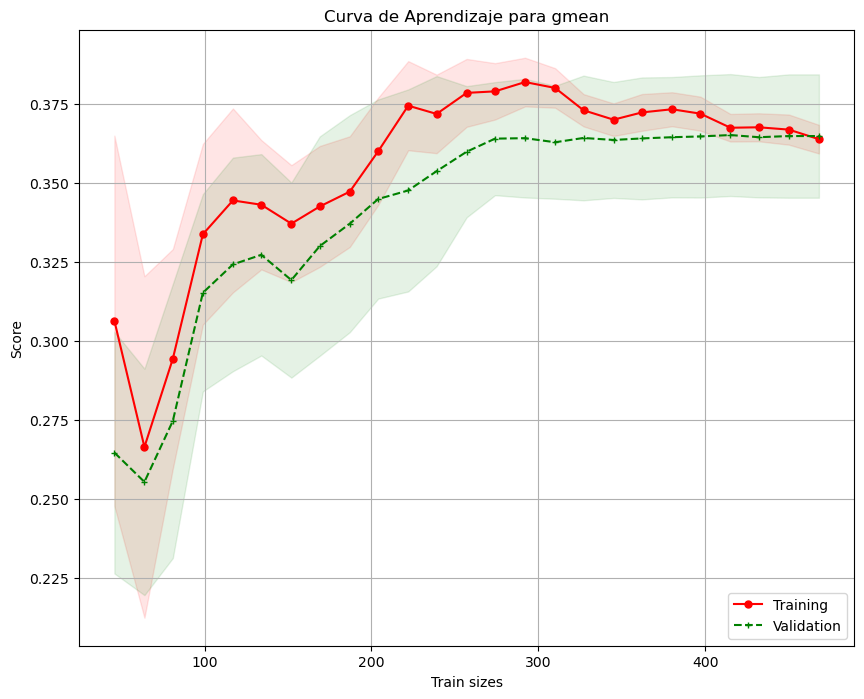

In [486]:
#Generamos las curvas para cada uno de los modelos
for metric, model in best_models.items():
    plot_learning_curve(
        model.named_steps['modelo'], 
        Xtrain, ytrain.values.ravel(), 
        kfold, 
        title = f"Curva de Aprendizaje para {metric}", 
        scoring = make_scorer(scorings[metric]))

De las curvas anteriores se puede observar que el mejor modelo para el accuracy se encuentra sobreentrenado, mientras que f1 y recall están subentrenados. En el caso del recall, este es el que presenta mejor desempeño de todas, ya que su varianza es prácticamente nula y su bias no es muy alto. Sin embargo, agregar más datos al conjunto no mejorará el desempeño de este modelo, como se observa en el gráfico.

Con relación a precision, se observa que su desempeño empeora lentamente a medida que se agregan más observaciones.

Por tanto, de lo anterior se confirma que recall sigue siendo el modelo con mejor desempeño entre todos.

#### **Ejercicio 7 - Curva ROC**

Ahora procederemos a realizar las curvas ROC para cada uno de los modelos, para luego ajustar el threshold para obtener el mejor desempeño.

In [487]:
#Función que gráfica las curva ROC
def plot_ROC_curve(model, x, y, tp_rate, fp_rate, title, radius = None):
  

  RocCurveDisplay.from_estimator(model, x, y, name="SVM Model")

  plt.plot([0,0,1,0], [0,1,1,0], 'y--')
  plt.title(title)
  plt.hlines(tp_rate, 0, fp_rate, colors = 'r', linestyles = 'dotted')
  plt.vlines(fp_rate, 0, tp_rate, colors = 'r', linestyles = 'dotted')

  if radius != None:
    an = np.linspace(1.5*np.pi, 2*np.pi, 20)
    plt.plot(radius*np.cos(an), radius*np.sin(an)+1)
    plt.axis('equal')
 

  plt.show()

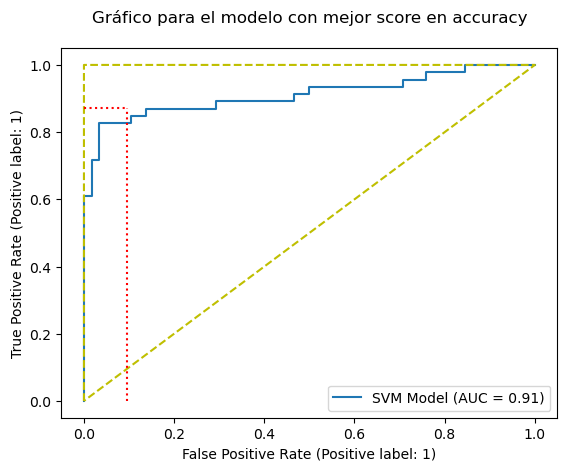

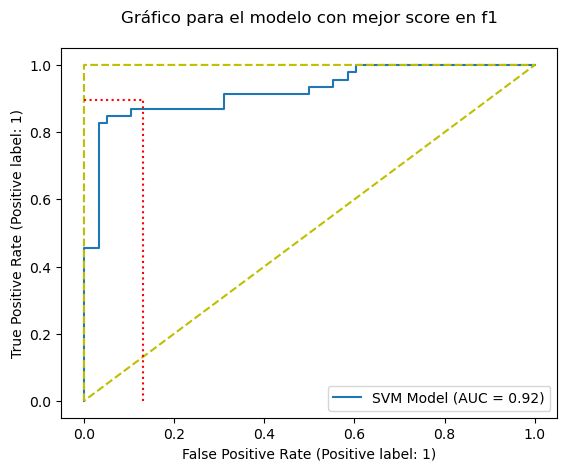

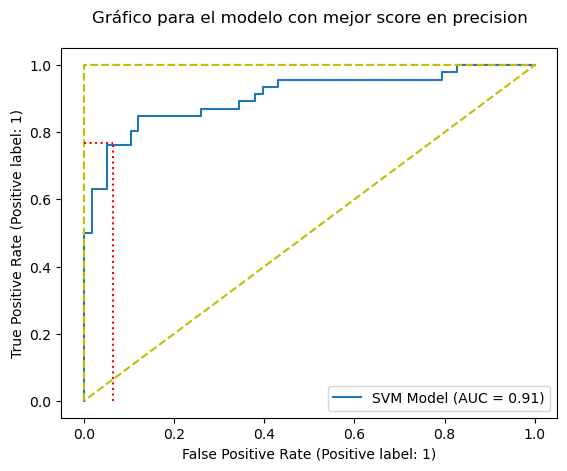

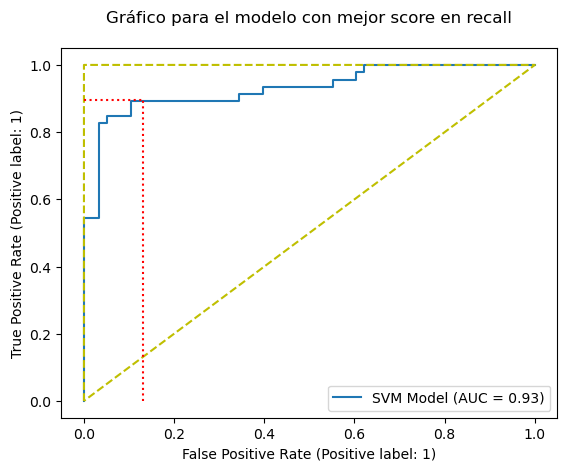

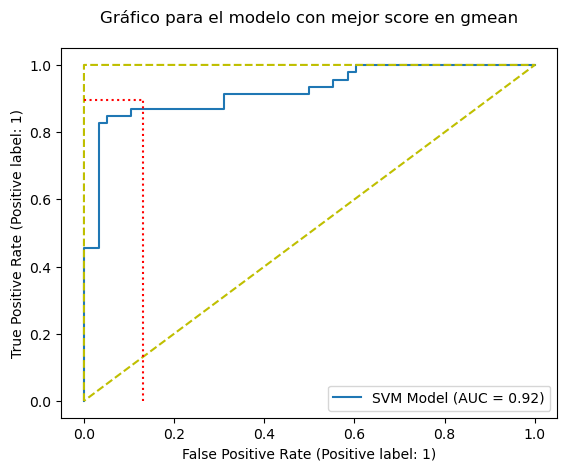

In [488]:
#Generamos las curvas para cada uno de los modelos
for metric, model in best_models.items():
    predictions = model.predict(Xtest)

    tp_rate = calc_sensitivity(ytest, predictions) #tp_rate usando el threshold por default, que es 0.5
    fp_rate = 1 - calc_specificity(ytest, predictions) #fp_rate usando el threshold por default, el cual es de 0.5 también

    
    plot_ROC_curve(model, Xtest, ytest,tp_rate, fp_rate, f"Gráfico para el modelo con mejor score en {metric}\n")

De los gráficos anteriores se puede observar que todas las predicciones cayeron en la parte izquierda de la línea verde (la que indica que la proporción de los verdaderos positivos es igual a la proporción de falsos positivos). Esto significa que para todas las predicciones de estos modelos, la proporción de verdaderos positivos fue mayor que la proporción de los falsos positivos, lo cual es un resultado deseado.

Lo anterior también puede demostrarse con el área bajo la curva, el cual es mayor a 0.90 para todos los modelos. Esto indica que las predicciones realizadas por los modelos es mejor a que si se hiciera  al azar (donde AUC = 0.5).

#### **Ejercicio 8 - Umbral óptimo para f1-score.**

Ahora procederemos a buscar el mejor umbral que maximiza la proporción de los verdaderos positivos y minimiza los falsos positivos. Para esto nos basaremos en el uso de una circunferencia que sea tangente a la curva ROC. El punto de la tangente sería nuestro valor óptimo.

Primero definiremos las funciones que estaremos utilizando para este método.

In [489]:
def fun_thTPrate(th, model, x, y):
    p = model.predict_proba(x)  

    my1s = (y['A15']==1) 
    pred1s  = p[my1s][:,1]
    return sum(pred1s > th) / sum(my1s)

def fun_thFPrate(th, model, x, y):
    p = model.predict_proba(x)
    my0s = (y['A15']==0) 
    pred0s  = p[my0s][:,1]
    return sum(pred0s>th) / sum(my0s)

A continuación, generamos los valores umbrales para los modelos que maximizan f1-score y gmean.

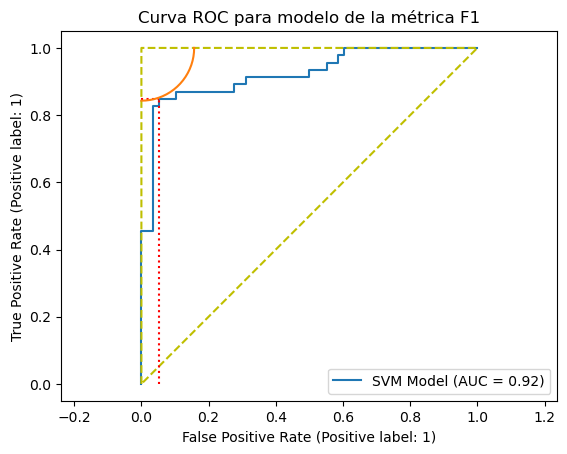

In [599]:
best_model_f1 = best_models["f1"]
new_th = 0.73
new_rr = 0.157
new_TPrate = fun_thTPrate(new_th, best_model_f1, Xtest, ytest)
new_FPrate = fun_thFPrate(new_th, best_model_f1, Xtest, ytest)


plot_ROC_curve(
    best_model_f1, 
    Xtest, ytest, 
    new_TPrate, 
    new_FPrate, 
    'Curva ROC para modelo de la métrica F1', 
    radius = new_rr)


#**Ejercicio-9.**

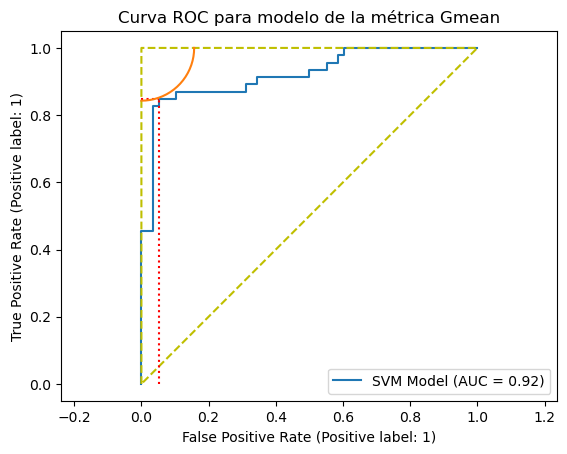

In [600]:
best_model_gmean = best_models["gmean"]

new_th = 0.72
new_rr = 0.157

new_TPrate = fun_thTPrate(new_th, best_model_gmean, Xtest, ytest)
new_FPrate = fun_thFPrate(new_th, best_model_gmean, Xtest, ytest)

plot_ROC_curve(
    best_model_gmean, 
    Xtest, ytest, 
    new_TPrate, 
    new_FPrate, 
    'Curva ROC para modelo de la métrica Gmean', 
    radius = new_rr)

Para ambos modelos se conluye que el mejor valor umbral es de 0.73 para el modelo de f1-score y 0.72 para gmean, ambos con un radio de 0.157

#### **Ejercicio 10 - Conclusiones**

* El modelo que maximiza el accuracy está sobreentrenado debido a la brecha que existe entre el desempeño del conjunto de entrenamiento vs el conjunto de validación (varianza). También está subentrenado debido a que existe un bias considerable en el desempeño del modelo en el conjunto de entrenamiento. Además, este bias tiene una tendencia a incrementar en el conjunto de entrenamiento a medida que los tamaños de las muestras aumenta, aunque con una disminución de la varianza.
  
* El modelo del f1-score tiene una varianza baja, por lo que no muestra sobreentrenamiento, pero si un bias importante, por lo que existe subentrenamiento. 
  
* En el caso de la métrica precision se puede apreciar subentrenamiento, pero esto porque el bias incremente ligeramente a medida que los tamaños de las muestra aumentan. Esto se puede visualizar en la tendencia de la curva que se presenta en el gráfico.

* El mejor comportamiento lo tuvo el modelo para la métrica recall, puesto que su varianza es prácticamente nula y el bias es relativamente bajo.
  
* Con relación a las curvas ROC, se observa que todos los modelos tuvieron un mejor desempeño a que si las predicciones se hiciesen al azar. Esto también puede confirmarse al comparar las métricas de cada modelo con las realizadas por el modelo Dummy.
  
* Al modificar los valores umbrales de las métricas f1 y gmean, se obtienen los umbrales 0.73 y 0.72 para dichas métricas, respectivamente. Esto se hizo buscando el punto tangente de la curva ROC a una circunferencia.
  
* Por último, se recomienda utilizar una curva precision/recall para contrastarlo con los resultados obtenidos en este ejercicio.

#### **Bibliografía**


* Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. Sebastopol: O’Reilly Media
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning (2da ed.)
* Russell, S. & Norvig, P. (2016). Artificial Intelligence: A Modern Approach. Pearson. (4ta. ed.)

###**Fin de la Actividad de la semana 8.**